In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
print('done')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import timm
from tqdm import tqdm
import random

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MangoLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in class folders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - w) // 2
        vp = (max_wh - h) // 2
        padding = (hp, vp, hp, vp)
        return TF.pad(image, padding, 0, 'constant')

def custom_resize_pad(image):
    """Resize to 224x112 maintaining aspect ratio, then pad to 224x224"""
    # Resize maintaining aspect ratio
    w, h = image.size
    new_h = 112
    new_w = int(w * (new_h / h))
    if new_w > 224:  # If width exceeds target
        new_w = 224
        new_h = int(h * (new_w / w))
    
    image = TF.resize(image, (new_h, new_w))
    
    # Pad to square
    padding_left = (224 - new_w) // 2
    padding_right = 224 - new_w - padding_left
    padding_top = (224 - new_h) // 2
    padding_bottom = 224 - new_h - padding_top
    
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    return TF.pad(image, padding, 0, 'constant')

# Define the transforms
data_transform = transforms.Compose([
    transforms.Lambda(custom_resize_pad),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and prepare the dataset
def prepare_data(data_dir, batch_size=32):
    dataset = MangoLeafDataset(root_dir=data_dir, transform=data_transform)
    
    # Calculate the split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split the dataset
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, dataset.classes

# Model preparation
def create_model(num_classes):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model, history

# Evaluation function
def evaluate_model(model, val_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    sample_images = []
    sample_preds = []
    sample_labels = []
    sample_paths = []
    
    with torch.no_grad():
        for inputs, labels, paths in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect samples for visualization
            if len(sample_images) < 10:
                batch_samples = min(10 - len(sample_images), len(inputs))
                for i in range(batch_samples):
                    sample_images.append(inputs[i].cpu())
                    sample_preds.append(preds[i].item())
                    sample_labels.append(labels[i].item())
                    sample_paths.append(paths[i])
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # Generate classification report
    cr = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Visualize sample predictions
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (img, pred, label, path) in enumerate(zip(sample_images, sample_preds, sample_labels, sample_paths)):
        # Denormalize image
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        color = 'green' if pred == label else 'red'
        title = f"Pred: {classes[pred]}\nTrue: {classes[label]}"
        axes[i].set_title(title, color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.close()
    
    return all_preds, all_labels, sample_images, sample_preds, sample_labels, sample_paths

# Function to extract and visualize attention
# def visualize_attention(model, img_path, transform, classes):
#     # Load and preprocess the image
#     img = Image.open(img_path).convert('RGB')
#     input_tensor = transform(img).unsqueeze(0).to(device)
    
#     # Get the predicted class
#     model.eval()
#     with torch.no_grad():
#         output = model(input_tensor)
#         _, predicted = torch.max(output, 1)
#         predicted_class = predicted.item()
    
#     # Extract attention weights from a specific layer
#     # Note: This is specific to the ViT implementation in timm
#     def get_attention(model, input_tensor):
#         # Get attention from the last layer (11)
#         hooks = []
#         attention_maps = []
        
#         def hook_fn(module, input, output):
#             attention_maps.append(output[1])
        
#         for name, module in model.named_modules():
#             if "attn" in name and "blocks.11" in name:
#                 hooks.append(module.register_forward_hook(hook_fn))
        
#         # Forward pass to extract attention
#         _ = model(input_tensor)
        
#         # Remove hooks
#         for hook in hooks:
#             hook.remove()
        
#         return attention_maps[0] if attention_maps else None
    
#     attention = get_attention(model, input_tensor)
    
#     if attention is not None:
#         # For ViT, attention is [batch_size, num_heads, seq_len, seq_len]
#         # The first element in seq_len is the [CLS] token
#         # We want to visualize how each patch attends to other patches
        
#         # Get attention from CLS token to image patches
#         # This shows which patches are most important for classification
#         cls_attention = attention[0, :, 0, 1:].mean(dim=0)  # Average over all heads
        
#         # Reshape attention to match the image patches
#         patch_size = 16  # for vit_base_patch16_224
#         num_patches = 14  # 224 / 16 = 14
#         attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()
        
#         # Visualize
#         plt.figure(figsize=(16, 8))
        
#         # Original image
#         plt.subplot(1, 2, 1)
#         img_np = np.array(img)
#         plt.imshow(img_np)
#         plt.title(f"Original Image\nPredicted: {classes[predicted_class]}")
#         plt.axis('off')
        
#         # Attention map
#         plt.subplot(1, 2, 2)
#         plt.imshow(attention_map, cmap='viridis')
#         plt.title(f"Attention Map (Layer 11)\nAttention from CLS token to patches")
#         plt.colorbar(label='Attention Intensity')
        
#         plt.tight_layout()
#         plt.savefig('attention_visualization.png')
#         plt.close()
        
#         # Overlay attention on original image
#         plt.figure(figsize=(10, 10))
        
#         # Resize attention map to match the original image size
#         h, w, _ = img_np.shape
#         upsampled_attention = np.zeros((h, w))
        
#         # Each cell in attention_map corresponds to a patch
#         for i in range(num_patches):
#             for j in range(num_patches):
#                 # Calculate patch boundaries
#                 top = i * patch_size
#                 left = j * patch_size
#                 bottom = min(top + patch_size, h)
#                 right = min(left + patch_size, w)
                
#                 # Fill patch area with attention value
#                 upsampled_attention[top:bottom, left:right] = attention_map[i, j]
        
#         # Normalize for better visualization
#         upsampled_attention = (upsampled_attention - upsampled_attention.min()) / (upsampled_attention.max() - upsampled_attention.min())
        
#         # Plot original image with attention overlay
#         plt.imshow(img_np)
#         plt.imshow(upsampled_attention, cmap='jet', alpha=0.5)
#         plt.title(f"Attention Overlay\nPredicted: {classes[predicted_class]}")
#         plt.axis('off')
        
#         plt.tight_layout()
#         plt.savefig('attention_overlay.png')
#         plt.close()
        
#         return attention_map, predicted_class
#     else:
#         print("Could not extract attention weights")
#         return None, predicted_class

# Function to extract and visualize attention
def visualize_attention(model, img_path, transform, classes):
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Get the predicted class
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
    
    # Extract attention weights from a specific layer
    # For timm's ViT implementation, we need a different approach
    attention_maps = []
    
    def hook_fn(module, input, output):
        # The structure may vary depending on the exact ViT implementation
        # For many implementations, attention is part of the input or 
        # can be computed from q, k, v
        try:
            # Try to extract attention weights
            # This might be different depending on timm version
            q, k, v = output[0], output[1], output[2]  # Assuming output contains q, k, v
            attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
            attention = torch.softmax(attention, dim=-1)
            attention_maps.append(attention.detach())
        except:
            # If the above doesn't work, we'll have to find another way
            print("Could not extract attention from this layer")
    
    hooks = []
    # Look for attention modules in the model
    for name, module in model.named_modules():
        if "attn" in name and "blocks.11" in name:
            # We're specifically looking for the attention mechanism
            # in the last transformer block (block 11)
            hooks.append(module.register_forward_hook(hook_fn))
    
    # Forward pass to extract attention
    _ = model(input_tensor)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    if attention_maps:
        # For ViT, attention shape is typically [batch_size, num_heads, seq_len, seq_len]
        attention = attention_maps[0]  # Get the first (and likely only) attention map
        
        # Get attention from all heads for the CLS token to all patches
        # The first token (0) is the CLS token
        cls_attention = attention[0, :, 0, 1:].mean(dim=0)  # Average over all heads
        
        # Reshape attention to match the image patches
        patch_size = 16  # for vit_base_patch16_224
        num_patches = int(math.sqrt(cls_attention.size(0)))  # Should be 14 for 224/16
        
        # Reshape to square grid
        attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()
        
        # Visualize
        plt.figure(figsize=(16, 8))
        
        # Original image
        plt.subplot(1, 2, 1)
        img_np = np.array(img)
        plt.imshow(img_np)
        plt.title(f"Original Image\nPredicted: {classes[predicted_class]}")
        plt.axis('off')
        
        # Attention map
        plt.subplot(1, 2, 2)
        plt.imshow(attention_map, cmap='viridis')
        plt.title(f"Attention Map (Layer 11)\nAttention from CLS token to patches")
        plt.colorbar(label='Attention Intensity')
        
        plt.tight_layout()
        plt.savefig('attention_visualization.png')
        plt.close()
        
        # Overlay attention on original image
        plt.figure(figsize=(10, 10))
        
        # Resize attention map to match the original image size
        h, w, _ = img_np.shape
        upsampled_attention = np.zeros((h, w))
        
        # Each cell in attention_map corresponds to a patch
        for i in range(num_patches):
            for j in range(num_patches):
                # Calculate patch boundaries
                top = i * patch_size
                left = j * patch_size
                bottom = min(top + patch_size, h)
                right = min(left + patch_size, w)
                
                # Fill patch area with attention value
                upsampled_attention[top:bottom, left:right] = attention_map[i, j]
        
        # Normalize for better visualization
        if upsampled_attention.max() > upsampled_attention.min():  # Avoid division by zero
            upsampled_attention = (upsampled_attention - upsampled_attention.min()) / (upsampled_attention.max() - upsampled_attention.min())
        
        # Plot original image with attention overlay
        plt.imshow(img_np)
        plt.imshow(upsampled_attention, cmap='jet', alpha=0.5)
        plt.title(f"Attention Overlay\nPredicted: {classes[predicted_class]}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('attention_overlay.png')
        plt.close()
        
        return attention_map, predicted_class
    else:
        # If we couldn't get attention, implement a fallback visualization
        print("Could not extract attention weights. Providing a fallback visualization.")
        
        # Create a gradient-based visualization instead
        # This creates a saliency map showing which pixels most affect the prediction
        model.zero_grad()
        input_tensor.requires_grad_(True)
        
        output = model(input_tensor)
        score = output[0, predicted_class]
        score.backward()
        
        # Get the gradients
        gradients = input_tensor.grad.abs().sum(dim=1).squeeze().cpu().numpy()
        
        # Normalize for visualization
        gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min() + 1e-8)
        
        # Visualize
        plt.figure(figsize=(16, 8))
        
        # Original image
        plt.subplot(1, 2, 1)
        img_np = np.array(img)
        plt.imshow(img_np)
        plt.title(f"Original Image\nPredicted: {classes[predicted_class]}")
        plt.axis('off')
        
        # Saliency map
        plt.subplot(1, 2, 2)
        plt.imshow(gradients, cmap='viridis')
        plt.title(f"Saliency Map (Gradient-based)")
        plt.colorbar(label='Gradient Magnitude')
        
        plt.tight_layout()
        plt.savefig('saliency_visualization.png')
        plt.close()
        
        # Also add the import at the top of your file:
        # import math
        
        # Return a placeholder attention map
        placeholder = np.zeros((14, 14))  # 14x14 is the number of patches for 224x224 image with 16x16 patches
        return placeholder, predicted_class



Using device: cuda
Preparing data...
Classes: ['ANTHRACNOSE', 'BACTERIAL CRANKER', 'DIEBACK', 'GALL MILDGE', 'HEALTHY', 'MANGO SOOTY', 'SOOTY MOULD']
Number of classes: 7
Creating model...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training model...


Epoch 1/5 [Val]: 100%|██████████| 23/23 [00:31<00:00,  1.37s/it]


Epoch 1/5
Train Loss: 0.8741, Train Acc: 0.7089
Val Loss: 0.5094, Val Acc: 0.8106


Epoch 2/5 [Val]: 100%|██████████| 23/23 [00:28<00:00,  1.26s/it]


Epoch 2/5
Train Loss: 0.3621, Train Acc: 0.8907
Val Loss: 0.3706, Val Acc: 0.9025


Epoch 3/5 [Val]: 100%|██████████| 23/23 [00:27<00:00,  1.22s/it]


Epoch 3/5
Train Loss: 0.1969, Train Acc: 0.9422
Val Loss: 0.5203, Val Acc: 0.8440


Epoch 4/5 [Val]: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch 4/5
Train Loss: 0.1763, Train Acc: 0.9526
Val Loss: 0.5144, Val Acc: 0.8412


Epoch 5/5 [Val]: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch 5/5
Train Loss: 0.1456, Train Acc: 0.9624
Val Loss: 0.3415, Val Acc: 0.8997
Evaluating model...
Confusion Matrix:

Classification Report:
                   precision    recall  f1-score   support

      ANTHRACNOSE       0.87      0.84      0.85        55
BACTERIAL CRANKER       0.75      0.77      0.76        47
          DIEBACK       1.00      0.80      0.89        10
      GALL MILDGE       1.00      0.94      0.97        18
          HEALTHY       0.94      0.95      0.94       126
      MANGO SOOTY       0.95      0.98      0.97        43
      SOOTY MOULD       0.89      0.90      0.89        60

         accuracy                           0.90       359
        macro avg       0.91      0.88      0.90       359
     weighted avg       0.90      0.90      0.90       359

Visualizing attention for correctly classified image: /kaggle/input/mangoleaf-disease/Full_mangoleaf_dataset/BACTERIAL CRANKER/IMG_4594.jpg


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [4]:
def main():
    # Set data directory - adjust this to your Kaggle dataset path
    data_dir = '/kaggle/input/mangoleaf-disease/Full_mangoleaf_dataset'  # Change this to your dataset path
    
    # Prepare data
    print("Preparing data...")
    train_loader, val_loader, classes = prepare_data(data_dir, batch_size=16)
    num_classes = len(classes)
    
    print(f"Classes: {classes}")
    print(f"Number of classes: {num_classes}")
    
    # Create and train model
    print("Creating model...")
    model = create_model(num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    print("Training model...")
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    
    # Evaluate model
    print("Evaluating model...")
    all_preds, all_labels, sample_images, sample_preds, sample_labels, sample_paths = evaluate_model(model, val_loader, classes)
    
    # Find a correctly classified image for attention visualization
    correct_indices = [i for i in range(len(sample_preds)) if sample_preds[i] == sample_labels[i]]
    
    if correct_indices:
        correct_idx = correct_indices[0]
        correct_img_path = sample_paths[correct_idx]
        
        print(f"Visualizing attention for correctly classified image: {correct_img_path}")
        attention_map, predicted_class = visualize_attention(model, correct_img_path, data_transform, classes)
    else:
        print("No correctly classified images found in the sample. Using the first image.")
        attention_map, predicted_class = visualize_attention(model, sample_paths[0], data_transform, classes)
    
    # Generate final report
    print("\nAnalysis complete!")
    print("All results have been saved as images for your report.")

if __name__ == "__main__":
    main()

Preparing data...
Classes: ['ANTHRACNOSE', 'BACTERIAL CRANKER', 'DIEBACK', 'GALL MILDGE', 'HEALTHY', 'MANGO SOOTY', 'SOOTY MOULD']
Number of classes: 7
Creating model...
Training model...


Epoch 1/2 [Val]: 100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


Epoch 1/2
Train Loss: 0.8234, Train Acc: 0.7166
Val Loss: 0.3276, Val Acc: 0.9109


Epoch 2/2 [Val]: 100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


Epoch 2/2
Train Loss: 0.3270, Train Acc: 0.8921
Val Loss: 0.3952, Val Acc: 0.8607
Evaluating model...
Confusion Matrix:

Classification Report:
                   precision    recall  f1-score   support

      ANTHRACNOSE       0.90      0.86      0.88        51
BACTERIAL CRANKER       0.59      0.91      0.72        43
          DIEBACK       1.00      0.92      0.96        12
      GALL MILDGE       1.00      0.94      0.97        17
          HEALTHY       0.90      0.92      0.91       134
      MANGO SOOTY       0.94      0.86      0.90        37
      SOOTY MOULD       0.94      0.68      0.79        65

         accuracy                           0.86       359
        macro avg       0.90      0.87      0.87       359
     weighted avg       0.88      0.86      0.86       359

Visualizing attention for correctly classified image: /kaggle/input/mangoleaf-disease/Full_mangoleaf_dataset/HEALTHY/IMG_20250304_115852.jpg


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import timm
from tqdm import tqdm
import random
import math  # Add this import

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MangoLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in class folders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - w) // 2
        vp = (max_wh - h) // 2
        padding = (hp, vp, hp, vp)
        return TF.pad(image, padding, 0, 'constant')

def custom_resize_pad(image):
    """Resize to 224x112 maintaining aspect ratio, then pad to 224x224"""
    # Resize maintaining aspect ratio
    w, h = image.size
    new_h = 112
    new_w = int(w * (new_h / h))
    if new_w > 224:  # If width exceeds target
        new_w = 224
        new_h = int(h * (new_w / w))
    
    image = TF.resize(image, (new_h, new_w))
    
    # Pad to square
    padding_left = (224 - new_w) // 2
    padding_right = 224 - new_w - padding_left
    padding_top = (224 - new_h) // 2
    padding_bottom = 224 - new_h - padding_top
    
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    return TF.pad(image, padding, 0, 'constant')

# Define the transforms
data_transform = transforms.Compose([
    transforms.Lambda(custom_resize_pad),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and prepare the dataset
def prepare_data(data_dir, batch_size=32):
    dataset = MangoLeafDataset(root_dir=data_dir, transform=data_transform)
    
    # Calculate the split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split the dataset
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, dataset.classes

# Model preparation
def create_model(num_classes):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model, history

# Evaluation function
def evaluate_model(model, val_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    sample_images = []
    sample_preds = []
    sample_labels = []
    sample_paths = []
    
    with torch.no_grad():
        for inputs, labels, paths in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect samples for visualization
            if len(sample_images) < 10:
                batch_samples = min(10 - len(sample_images), len(inputs))
                for i in range(batch_samples):
                    sample_images.append(inputs[i].cpu())
                    sample_preds.append(preds[i].item())
                    sample_labels.append(labels[i].item())
                    sample_paths.append(paths[i])
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # Generate classification report
    cr = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Visualize sample predictions
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (img, pred, label, path) in enumerate(zip(sample_images, sample_preds, sample_labels, sample_paths)):
        # Denormalize image
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        color = 'green' if pred == label else 'red'
        title = f"Pred: {classes[pred]}\nTrue: {classes[label]}"
        axes[i].set_title(title, color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.close()
    
    return all_preds, all_labels, sample_images, sample_preds, sample_labels, sample_paths

# Simplified attention visualization using gradient-based method
def visualize_attention(model, img_path, transform, classes):
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    original_img = np.array(img)
    
    # Create input tensor that requires gradient
    input_tensor = transform(img).unsqueeze(0).to(device)
    input_tensor.requires_grad = True
    
    # Get the predicted class
    model.eval()
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()
    predicted_class_name = classes[predicted_class]
    
    # Calculate gradients with respect to the predicted class
    model.zero_grad()
    class_score = output[0, predicted_class]
    class_score.backward()
    
    # Get gradients and create saliency map
    gradients = input_tensor.grad.abs().cpu().detach()
    # Sum over channels
    saliency_map = gradients.sum(dim=1).squeeze().numpy()
    
    # Normalize saliency map for visualization
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)
    
    # Resize saliency map to match original image
    h, w = original_img.shape[:2]
    import cv2
    saliency_map_resized = cv2.resize(saliency_map, (w, h))
    
    # Create visualizations
    plt.figure(figsize=(16, 8))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original Image\nPredicted: {predicted_class_name}")
    plt.axis('off')
    
    # Saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map_resized, cmap='viridis')
    plt.title(f"Gradient-based Importance Map")
    plt.colorbar(label='Feature Importance')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('importance_map.png')
    plt.close()
    
    # Overlay importance map on original image
    plt.figure(figsize=(10, 10))
    plt.imshow(original_img)
    plt.imshow(saliency_map_resized, cmap='jet', alpha=0.5)
    plt.title(f"Feature Importance Overlay\nPredicted: {predicted_class_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('importance_overlay.png')
    plt.close()
    
    print(f"Prediction: {predicted_class_name}")
    print("Visualization saved as 'importance_map.png' and 'importance_overlay.png'")
    
    return saliency_map_resized, predicted_class

def main():
    # Set data directory - adjust this to your Kaggle dataset path
    data_dir = '/kaggle/input/mangoleaf-disease/Full_mangoleaf_dataset'  # Change this to your dataset path
    
    # Prepare data
    print("Preparing data...")
    train_loader, val_loader, classes = prepare_data(data_dir, batch_size=16)
    num_classes = len(classes)
    
    print(f"Classes: {classes}")
    print(f"Number of classes: {num_classes}")
    
    # Create and train model
    print("Creating model...")
    model = create_model(num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    print("Training model...")
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    
    # Evaluate model
    print("Evaluating model...")
    all_preds, all_labels, sample_images, sample_preds, sample_labels, sample_paths = evaluate_model(model, val_loader, classes)
    
    # Find a correctly classified image for attention visualization
    correct_indices = [i for i in range(len(sample_preds)) if sample_preds[i] == sample_labels[i]]
    
    if correct_indices:
        correct_idx = correct_indices[0]
        correct_img_path = sample_paths[correct_idx]
        
        print(f"Visualizing feature importance for correctly classified image: {correct_img_path}")
        _, _ = visualize_attention(model, correct_img_path, data_transform, classes)
    else:
        print("No correctly classified images found in the sample. Using the first image.")
        _, _ = visualize_attention(model, sample_paths[0], data_transform, classes)
    
    # Generate final report
    print("\nAnalysis complete!")
    print("All results have been saved as images for your report.")

if __name__ == "__main__":
    main()

Using device: cuda
Preparing data...
Classes: ['ANTHRACNOSE', 'BACTERIAL CRANKER', 'DIEBACK', 'GALL MILDGE', 'HEALTHY', 'MANGO SOOTY', 'SOOTY MOULD']
Number of classes: 7
Creating model...
Training model...


Epoch 1/5 [Val]: 100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


Epoch 1/5
Train Loss: 0.8741, Train Acc: 0.7089
Val Loss: 0.5094, Val Acc: 0.8106


Epoch 2/5 [Val]: 100%|██████████| 23/23 [00:19<00:00,  1.18it/s]


Epoch 2/5
Train Loss: 0.3621, Train Acc: 0.8907
Val Loss: 0.3706, Val Acc: 0.9025


Epoch 3/5 [Val]: 100%|██████████| 23/23 [00:20<00:00,  1.14it/s]


Epoch 3/5
Train Loss: 0.1969, Train Acc: 0.9422
Val Loss: 0.5203, Val Acc: 0.8440


Epoch 4/5 [Val]: 100%|██████████| 23/23 [00:20<00:00,  1.14it/s]


Epoch 4/5
Train Loss: 0.1763, Train Acc: 0.9526
Val Loss: 0.5144, Val Acc: 0.8412


Epoch 5/5 [Val]: 100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


Epoch 5/5
Train Loss: 0.1456, Train Acc: 0.9624
Val Loss: 0.3415, Val Acc: 0.8997
Evaluating model...
Confusion Matrix:

Classification Report:
                   precision    recall  f1-score   support

      ANTHRACNOSE       0.87      0.84      0.85        55
BACTERIAL CRANKER       0.75      0.77      0.76        47
          DIEBACK       1.00      0.80      0.89        10
      GALL MILDGE       1.00      0.94      0.97        18
          HEALTHY       0.94      0.95      0.94       126
      MANGO SOOTY       0.95      0.98      0.97        43
      SOOTY MOULD       0.89      0.90      0.89        60

         accuracy                           0.90       359
        macro avg       0.91      0.88      0.90       359
     weighted avg       0.90      0.90      0.90       359

Visualizing feature importance for correctly classified image: /kaggle/input/mangoleaf-disease/Full_mangoleaf_dataset/BACTERIAL CRANKER/IMG_4594.jpg
Prediction: BACTERIAL CRANKER
Visualization saved as 'i

In [6]:
import os
from IPython.display import Image, display


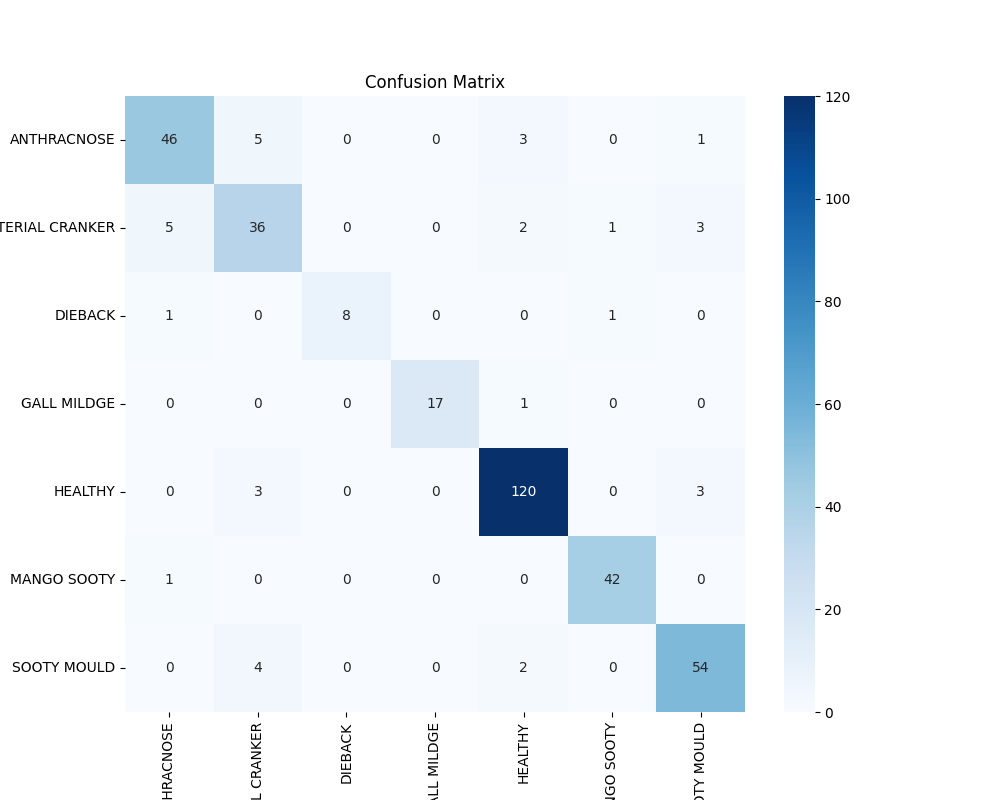

In [7]:
   display(Image(filename='/kaggle/working/confusion_matrix.png'))

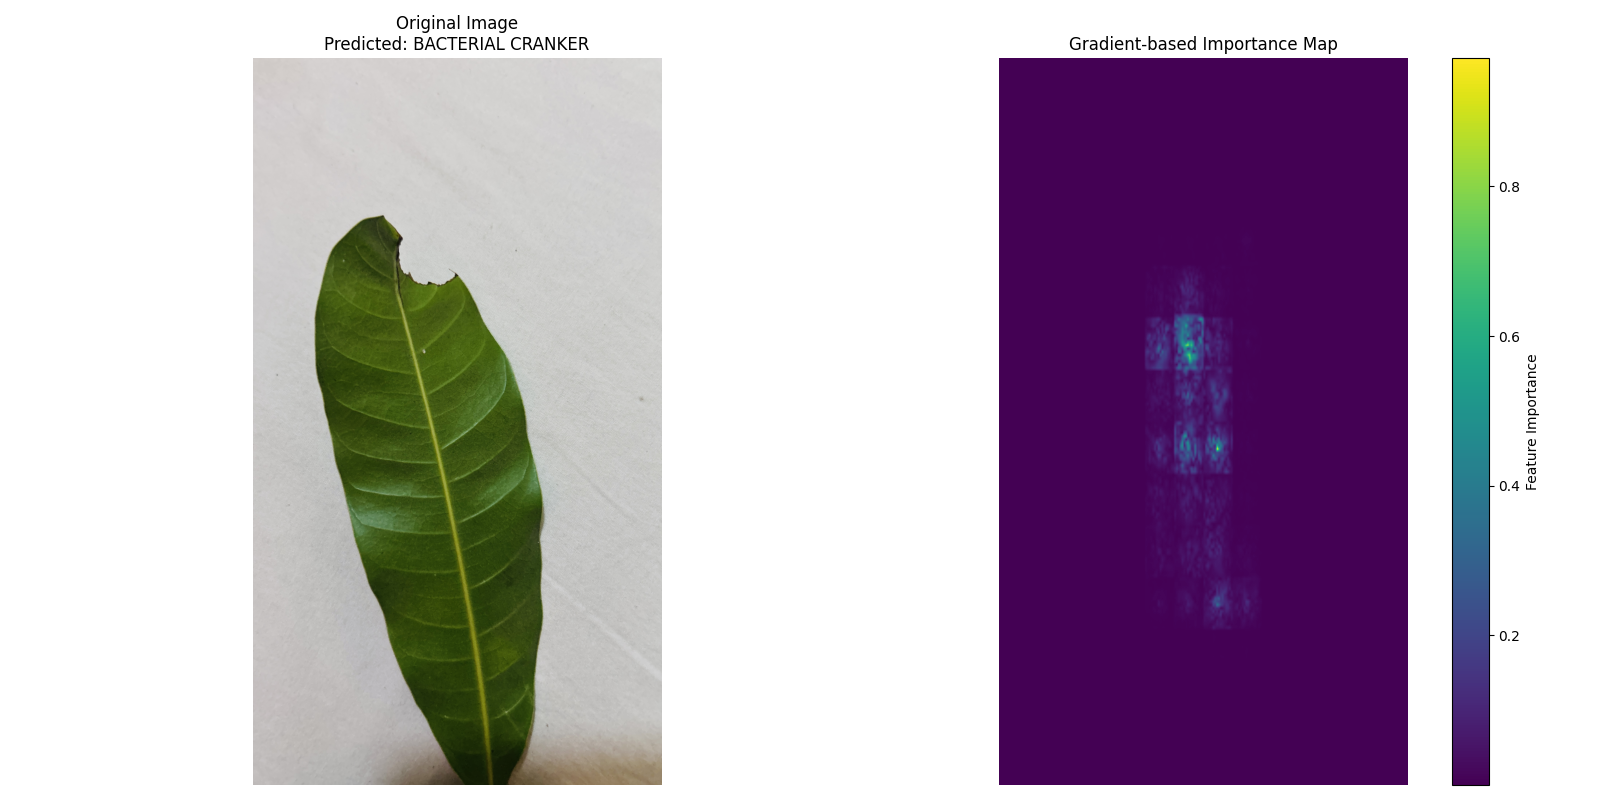

In [8]:
   display(Image(filename='//kaggle/working/importance_map.png'))

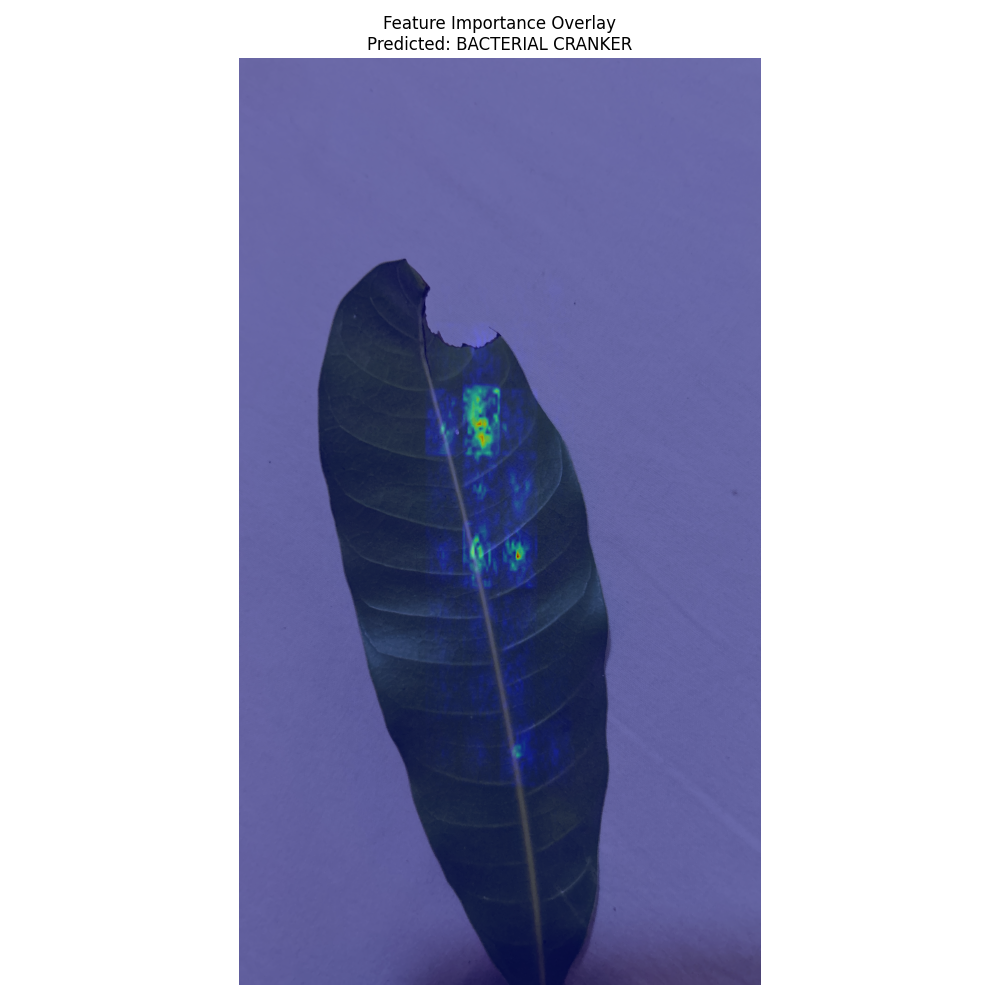

In [9]:
   display(Image(filename='/kaggle/working/importance_overlay.png'))

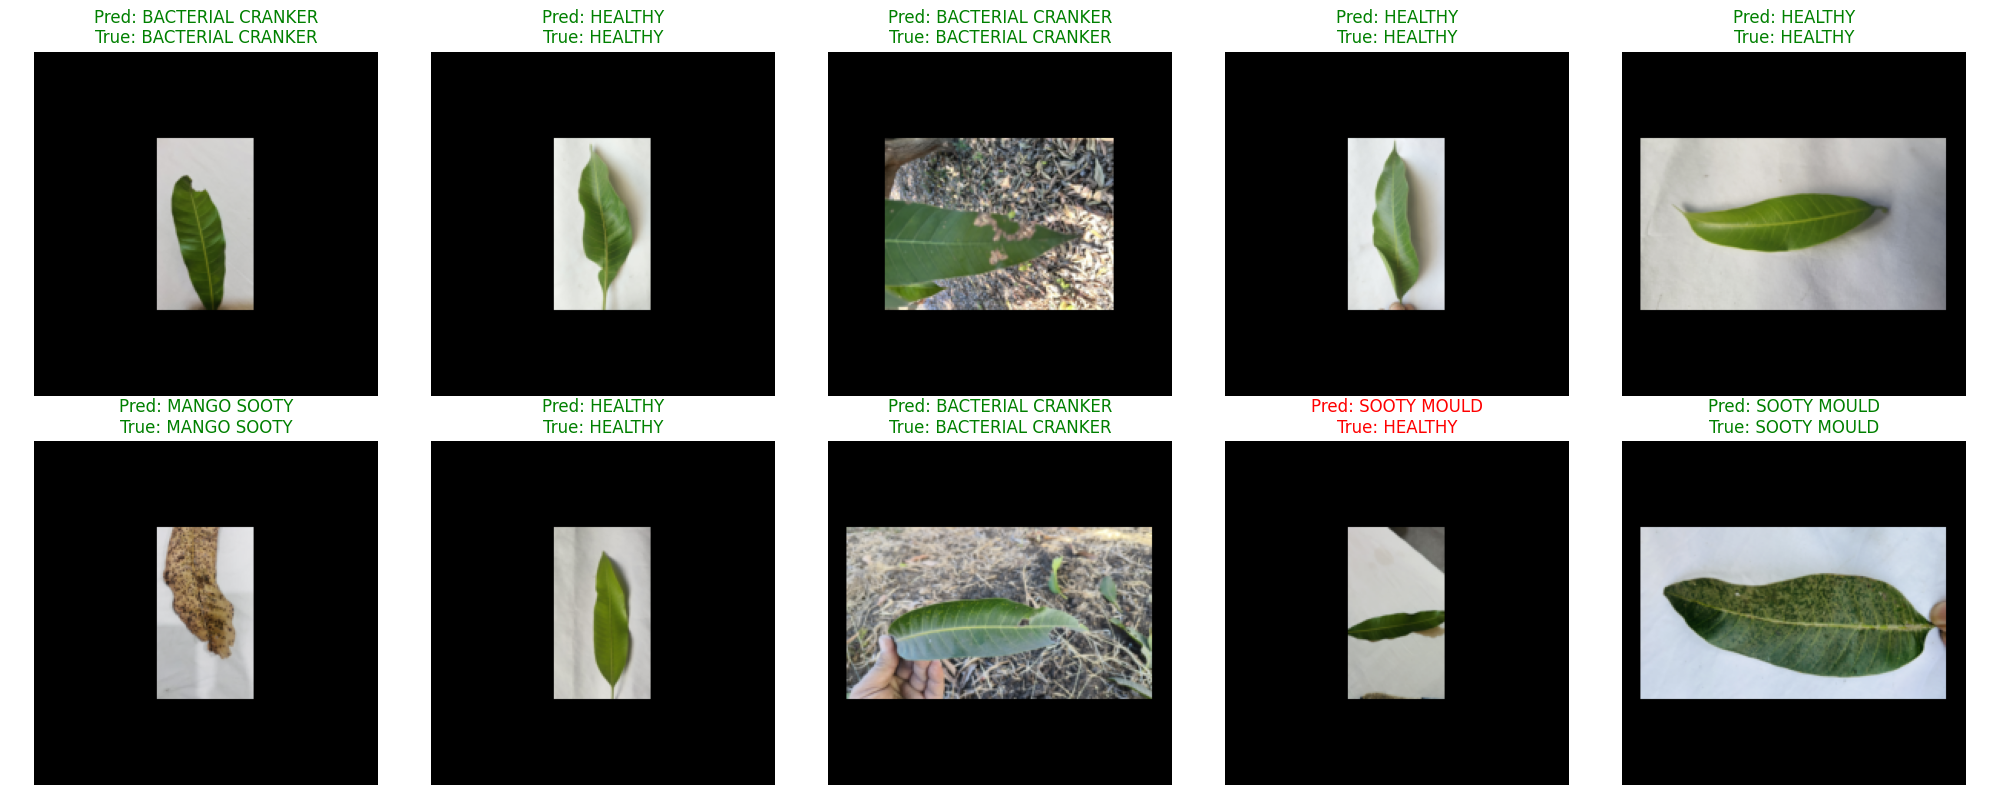

In [10]:
   display(Image(filename='/kaggle/working/sample_predictions.png'))